# Example 1: Learning molecules energy 

#### Huan Tran

The main objective of this example is to demonstrate a generic workflow of materials, involving (1) obtaining a small dataset of molecules and their energy, (2) fingerprint them, (3) develop some ML models, and (4) use these models to make predictions. 

***
### Plot learning results with matplotlib, to be used latter

In [1]:
def plot_result():
    import matplotlib.pyplot as plt
    from sklearn.metrics import r2_score
    import numpy as np

    print ('')
    print ('  Plot results in "training.csv" & "test.csv"')
    test_df=pd.read_csv('test.csv')
    train_df=pd.read_csv('training.csv')
    n_trains=len(train_df)
    n_tests=len(test_df)

    plt.figure(figsize=(6, 6))
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=12)
    plt.xlim([-25.6, -25.1])
    plt.ylim([-25.6, -25.1])
    plt.xticks(np.arange(-25.6, -25.1, 0.1))
    plt.yticks(np.arange(-25.6, -25.1, 0.1))
    rmse_train=np.sqrt(np.mean((train_df['target']-train_df['md_target'])**2))
    r2_train=r2_score(train_df['target'],train_df['md_target'])
    rmse_test=np.sqrt(np.mean((test_df['target']-test_df['md_target'])**2))
    r2_test=r2_score(test_df['target'],test_df['md_target'])
    plt.text(-25.56,-25.24,'n_trains: %s points\nn_tests: %s points\ntraining rmse: %.3f (eV)\ntest rmse: %.3f (eV)\ntraining r2: %.3f (eV)\ntest r2: %.3f (eV)'
        %(n_trains,n_tests,rmse_train,rmse_test,r2_train,r2_test),size=11)

    plt.tick_params(axis='x',which='both',bottom=True,top=False,labelbottom=True)
    plt.tick_params(axis='y',which='both',direction='in')
    plt.ylabel("Predicted value (eV)", size=14)
    plt.xlabel("Reference value (eV)", size = 14)
    plt.scatter(train_df['target'],train_df['md_target'],color='tab:red',alpha = 0.5,label='training data')
    plt.scatter(test_df['target'],test_df['md_target'],color='tab:blue',alpha = 0.5,label='test data')
    plt.legend(loc="lower right", fontsize = 13)
    plt.show()

***
### 1. Download data
The dataset contains 1000 non-equilibrium structures of CH4, whose energy was computed using BigDFT package. It is available at www.matsml.org.

In [2]:
import os
import pandas as pd

# get data
data_url='https://www.matsml.org/data/molecs.tgz'
os.system('wget -O molecs.tgz --no-check-certificate '+data_url)
os.system('tar -xf molecs.tgz')

# check necessary content
print (os.path.isfile('molecs/sum_list.csv'))
if os.path.isfile('molecs/sum_list.csv'):
    print (pd.read_csv('molecs/sum_list.csv'))

True
         file_name     target
0    CF4-00001.xyz -25.466963
1    CF4-00002.xyz -25.357728
2    CF4-00003.xyz -25.463676
3    CF4-00004.xyz -25.312495
4    CF4-00005.xyz -25.364009
..             ...        ...
395  CF4-00396.xyz -25.405787
396  CF4-00397.xyz -25.487477
397  CF4-00398.xyz -25.461510
398  CF4-00399.xyz -25.223929
399  CF4-00400.xyz -25.497948

[400 rows x 2 columns]


***
### 2. Fingerprint the obtained data
Coulomb matrix (CM) [M. Rupp, A. Tkatchenko, K.-R. Müller, and O. Anatole von Lilienfeld, <em>Fast and accurate modeling of molecular atomization energies with machine learning</em>, Phys. Rev. Lett., 108, 058301 (2012)] is perhaps one of the earliest fingerprints used in materials informatics. It was defined as an $N\times N$ matrix for a molecule of $N$ atoms. The key advantage of CM is that it is invariant under rotations and translations, required ro represent materials structure as a whole. However, its size depends on the molecule size, making it not directly usable for machine learning. Normally, the eigenvalues of these matricies are computed and sorted, and then zero padding is used to make fixed-size vectors. Here, we defined a projection of these Coulomb matricies onto a set of Gaussian functions, covering the entire range of the Coulomn matrix element values. The results are also a set of fixed-size fingerprints, which are ready for learning.

In [3]:
import pandas as pd
from matsml.fingerprint import Fingerprint

sum_list=os.path.join(os.getcwd(),'molecs/sum_list.csv')
data_loc=os.path.join(os.getcwd(),'molecs/')
n_atoms_max=6                          # max number of atoms in all of the structures to be fingerprinted
fp_type='pcm_molecs'                   # projected Coulomb matrix for molecules
struct_format='xyz'                    # atomic structure format 
fp_file='fp.csv'                       # fingerprinted data file name
fp_dim=100                             # intended fingerprint dimensionality
verbosity=0                            # verbosity, 0 or 1

data_params={'sum_list':sum_list,'data_loc':data_loc,'n_atoms_max':n_atoms_max,
    'fp_file':fp_file,'struct_format':struct_format,'fp_type':fp_type,
    'fp_dim':fp_dim,'verbosity':verbosity}

fp=Fingerprint(data_params)

# Compute fingerprint
fp.get_fingerprint()

# How does the fingerprinted data look like
print(pd.read_csv('fp.csv').columns)

  matsML, version 1.0
  *****
  Atomic structure fingerprinting
    sum_list                     /home/huan/work/matsml/examples/ex1_pcm-molecs/molecs/sum_list.csv
    data_loc                     /home/huan/work/matsml/examples/ex1_pcm-molecs/molecs/
    n_atoms_max                  6
    struct_format                xyz
    fp_type                      pcm_molecs
    fp_dim                       100
    fp_file                      fp.csv
    verbosity                    0
  Read input
    num_structs                  400
  Computing Coulomb matrix
    [==================================================] 100%
  Projecting Coulomb matrix to create fingerprints
    [==================================================] 100%
  Done fingerprinting, results saved in fp.csv
Index(['id', 'target', 'pcm_0018', 'pcm_0019', 'pcm_0020', 'pcm_0021',
       'pcm_0022', 'pcm_0023', 'pcm_0024', 'pcm_0025', 'pcm_0026', 'pcm_0027',
       'pcm_0028', 'pcm_0029', 'pcm_0030', 'pcm_0031', 'pcm_0032', 'pcm

***
### 3. Train some ML models
Having the fingerprinted data "fp.csv", whose fields shown above, it will now be learned. First, some specific information of the data is given. 

In [4]:
# data parameters for learning, note that this maybe different from data_params for the 
# above fingerprint step. We used the same data in "fp.csv" for all three algorithms below
data_file='fp.csv'        # fingerprinted data file
id_col=['id']             # column for data ID 
y_cols=['target']         # columns for (one or more) target properties
comment_cols=[]           # comment columns, anything not counted into ID, fingerprints, and target
n_trains=0.85             # 85% for training, 15% for validating
sampling='random'         # method for train/test spliting
x_scaling='minmax'        # method for x scaling
y_scaling='minmax'        # method for y scaling

# Dict of data parameters
data_params={'data_file':data_file, 'id_col':id_col,'y_cols':y_cols,
    'comment_cols':comment_cols,'y_scaling':y_scaling,'x_scaling':x_scaling,
    'sampling':sampling, 'n_trains':n_trains}

Then, three generic learning algorithms will be used. Depending on the algorithm, some method-specific parameters are needed so the model can be properly built and trained on the fingerprinted data.
***
#### 3a. Fully-connected NeuralNet

 
  Learning fingerprinted/featured data
    algorithm                    fully connected NeuralNet w/ TensorFlow
    layers                       [8, 8]
    activ_funct                  tanh
    epochs                       300
    optimizer                    nadam
    nfold_cv                     5
  Reading data ... 
    data file                    fp.csv
    data size                    400
    training size                340 (85.0 %)
    test size                    60 (15.0 %)
    x dimensionality             50
    y dimensionality             1
    y label(s)                   ['target']
  Scaling x                      minmax
  Scaling y                      minmax
  Prepare train/test sets        random
  Building model                 FCNeuralNet
  Training model w/ cross validation
    cv,rmse_train,rmse_test,rmse_opt: 0 0.057950 0.077600 0.077600
    cv,rmse_train,rmse_test,rmse_opt: 1 0.060975 0.069424 0.069424
    cv,rmse_train,rmse_test,rmse_opt: 2 0.060777 0.057246 

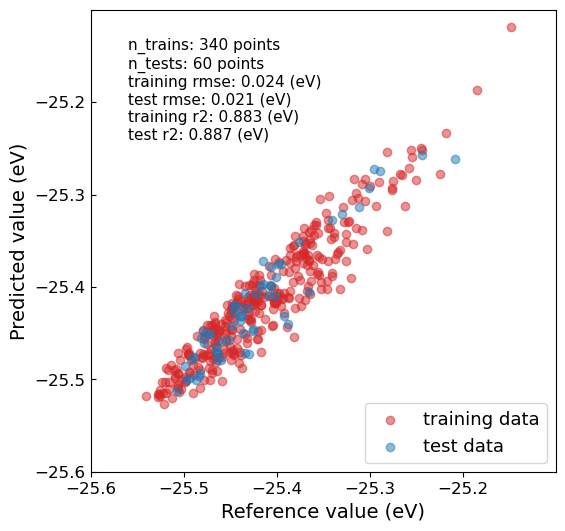

In [5]:
from matsml.models import FCNeuralNet

# Model parameters
layers=[8,8]                 # list of nodes in hidden layers
epochs=300                   # Epochs
nfold_cv=5                   # Number of folds for cross validation
use_bias=True                # Use bias term or not
model_file='model_nn.pkl'    # Name of the model file to be created
verbosity=0                  # Verbosity, 0 or 1
batch_size=32                # Default = 32
loss='mse'
metric='mse'
activ_funct='tanh'           # Options: "tanh","relu","sigmoid","softmax","softplus","softsign","selu","elu","exponential"
optimizer='nadam'            # options: "SGD","RMSprop","Adam","Adadelta","Adagrad","Adamax","Nadam","Ftrl"

# Dict of model parameters
model_params={'layers':layers,'activ_funct':activ_funct,'epochs':epochs,
    'nfold_cv':nfold_cv,'optimizer':optimizer,'use_bias':use_bias,
    'model_file':model_file,'loss':loss,'metric':metric,
    'batch_size':batch_size,'verbosity':verbosity,'rmse_cv':False}

# Compile a model
model=FCNeuralNet(data_params=data_params,model_params=model_params)

# Train the model
model.train()

# Plot results
plot_result()

***
#### 3b. Kernel Ridge Regression

 
  Learning fingerprinted/featured data
    algorithm                    kernel ridge regression w/ scikit-learn
    kernel                       rbf
    nfold_cv                     5
    alpha                        [-2, 5]
    gamma                        [-2, 5]
    number of alpha/gamma grids  10
  Checking parameters
  Reading data ... 
    data file                    fp.csv
    data size                    400
    training size                340 (85.0 %)
    test size                    60 (15.0 %)
    x dimensionality             50
    y dimensionality             1
    y label(s)                   ['target']
  Scaling x                      minmax
  Scaling y                      minmax
  Prepare train/test sets        random
  Building model                 KRR
  Training model w/ cross validation
  KRR model trained, now make predictions & invert scaling
    Unscaling y: minmax
       rmse training     target           0.023593
    Unscaling y: minmax
       rmse test   

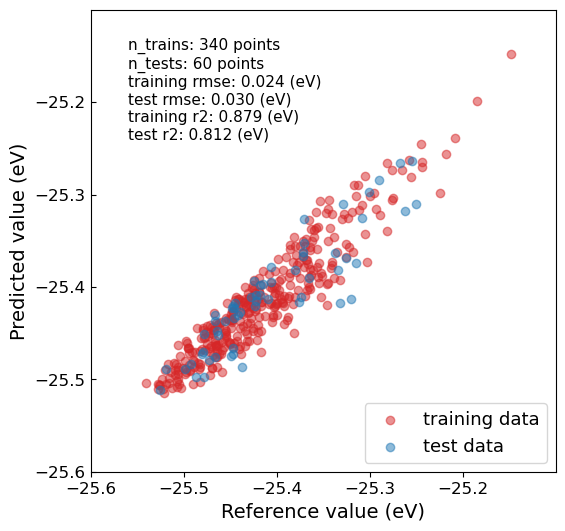

In [6]:
from matsml.models import KRR

# Model parameters
kernel = 'rbf'                 # Kernel
nfold_cv=5                     # Number of folds for cross validation
model_file='model_krr.pkl'     # Name of the model file to be created
metric = 'mse'                 # Metric
alpha = [-2,5]                 # hyper parameter range
gamma = [-2,5]                 # hyper parameter range
n_grids = 10

# Dict of model parameters
model_params={'kernel':kernel,'metric':metric,'nfold_cv':nfold_cv,
    'model_file':model_file,'alpha':alpha,'gamma':gamma,'n_grids':n_grids}

# Compile a model
model = KRR(data_params=data_params,model_params=model_params)

# Train the model
model.train()

# Plot results
plot_result()

***
#### 3c. Gaussian Process Regression

 
  Learning fingerprinted/featured data
    algorithm                    gaussian process regression w/ scikit-learn
    nfold_cv                     5
  Checking parameters
  Reading data ... 
    data file                    fp.csv
    data size                    400
    training size                340 (85.0 %)
    test size                    60 (15.0 %)
    x dimensionality             50
    y dimensionality             1
    y label(s)                   ['target']
  Scaling x                      minmax
  Scaling y                      minmax
  Prepare train/test sets        random
  Training model w/ cross validation


/home/huan/miniconda3/envs/tf/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/huan/miniconda3/envs/tf/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.003776543888568549. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


    cv,rmse_train,rmse_test,rmse_opt: 0 0.054092 0.065278 0.065278
    Unscaling y: minmax
       rmse cv_test      target           0.025613


/home/huan/miniconda3/envs/tf/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/huan/miniconda3/envs/tf/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.003776543888568549. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


    cv,rmse_train,rmse_test,rmse_opt: 1 0.051921 0.104365 0.065278
    Unscaling y: minmax
       rmse cv_test      target           0.040949


/home/huan/miniconda3/envs/tf/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/huan/miniconda3/envs/tf/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.003776543888568549. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


    cv,rmse_train,rmse_test,rmse_opt: 2 0.052747 0.075047 0.065278
    Unscaling y: minmax
       rmse cv_test      target           0.029446


/home/huan/miniconda3/envs/tf/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/huan/miniconda3/envs/tf/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.003776543888568549. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


    cv,rmse_train,rmse_test,rmse_opt: 3 0.053774 0.058664 0.058664
    Unscaling y: minmax
       rmse cv_test      target           0.023018


/home/huan/miniconda3/envs/tf/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/huan/miniconda3/envs/tf/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.003776543888568549. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


    cv,rmse_train,rmse_test,rmse_opt: 4 0.053626 0.060478 0.058664
    Unscaling y: minmax
       rmse cv_test      target           0.023729
  GPR model trained, now make predictions & invert scaling
    Unscaling y: minmax
       rmse training     target           0.02111
    Unscaling y: minmax
       rmse test         target           0.024591
  Predictions made & saved in "training.csv" & "test.csv"

  Plot results in "training.csv" & "test.csv"


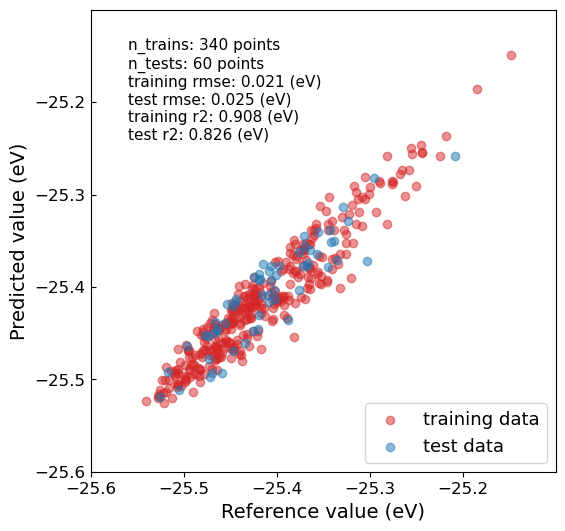

In [7]:
from matsml.models import GPR

# Model parameters
nfold_cv=5                         # Number of folds for cross validation
model_file='model_gpr.pkl'         # Name of the model file to be created
verbosity=0
rmse_cv=True                       # Compute CV RMSE or not
n_restarts_optimizer=100           # Number of optimizer start

# Dict of model parameters
model_params={'metric':metric,'nfold_cv':nfold_cv,
    'n_restarts_optimizer':n_restarts_optimizer,'model_file':model_file,
    'verbosity':verbosity,'rmse_cv':rmse_cv}

# Compile a model
model=GPR(data_params=data_params,model_params=model_params)

# Train the model
model.train()

# Plot results
plot_result()